<a href="https://colab.research.google.com/github/Franklingo13/ejemplosCopernicus/blob/main/ejemplosJupyter/deslizamineto_tierra_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enfoque basado en el NDVI para estudiar áreas de deslizamientos de tierra
Las investigaciones indican que el NDVI puede desempeñar un papel crucial en la identificación de zonas de deslizamientos. Si bien es posible un flujo de trabajo avanzado, este cuaderno opta por un enfoque simple que utiliza la diferencia del NDVI y aplica un umbral al resultado para detectar zonas de deslizamientos. Nuestro análisis se basa en la colección Sentinel-2 Nivel 2A, obtenida del ecosistema de datos de Copernicus mediante openEO.

In [1]:
%pip install openeo rasterio matplotlib numpy georeader-spaceml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.7.1
    Uninstalling xarray-2025.7.1:
      Successfully uninstalled xarray-2025.7.1


In [2]:
import openeo
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
import numpy as np
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=CCUK-YQXK 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [4]:
## Script para convertir un polígono de 4 puntos en geo json [lat, lomg] a un formato de diccionario {"west":__, "south":__, "east":__, "north":__}
aoi = {
    "type":"Polygon",
    "coordinates":[[[-80.241514,-0.811136],[-80.241514,-0.76219],
     [-80.172764,-0.76219],[-80.172764,-0.811136],[-80.241514,-0.811136]]]
    }

# Extraer las coordenadas del polígono
coordinates = aoi["coordinates"][0]

# Encontrar los valores mínimo y máximo para cada dimensión
west = min(coord[0] for coord in coordinates)
south = min(coord[1] for coord in coordinates)
east = max(coord[0] for coord in coordinates)
north = max(coord[1] for coord in coordinates)

# Crear el diccionario con el formato deseado
aoi_dict = {
    "west": west,
    "south": south,
    "east": east,
    "north": north,
}

print(aoi_dict)

{'west': -80.241514, 'south': -0.811136, 'east': -80.172764, 'north': -0.76219}


In [34]:
# Area de interés
spatial_extent = aoi_dict

# Periodo ANTES del evento.
# Se usa un mes completo para tener más posibilidades de encontrar imágenes sin nubes.
temporal_extent_pre = ["2025-01-01", "2025-02-21"]

# Periodo DESPUÉS del evento.
temporal_extent_post = ["2025-02-22", "2025-07-31"]

In [35]:
print("\n--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---")
print("\n--- Se calcula NDVI antes y después del evento ---")
print("\n--- diff = postndvi - prendvi ---")

# Cargar la colección de datos Sentinel-2
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'],
)

# Calcular el NDVI
prendvi = s2pre.ndvi().mean_time()

# Para el cubo de datos posterior, se carga la colección de datos Sentinel-2 con la extensión
# temporal comenzando desde el final de la extensión temporal previa al evento.
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
)

# Calcular el NDVI para el cubo de datos posterior
postndvi = s2post.ndvi().mean_time()
# Calcular la diferencia del NDVI
diff = postndvi - prendvi
# Ejecuta el proceso
diff.download("NDVIDiff.tiff")



--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---

--- Se calcula NDVI antes y después del evento ---

--- diff = postndvi - prendvi ---


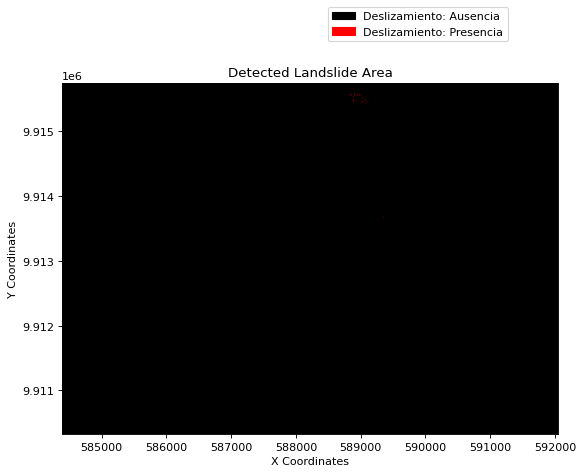

In [ ]:
# Graficar el resultado
# Cargar la imagen resultante
img = rasterio.open("NDVIDiff.tiff")

# Se aplica un umbral para resaltar las áreas de deslizamiento
value = img.read(1)
cmap = matplotlib.colors.ListedColormap(["black", "red"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
im = show(
    ((value < -0.48) & (value > -1)),
    vmin=0,
    vmax=1,
    cmap=cmap,
    transform=img.transform,
    ax=ax,
)
values = ["Ausencia", "Presencia"]
colors = ["black", "red"]
ax.set_title("Detected Landslide Area")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
patches = [
    mpatches.Patch(color=colors[i], label="Deslizamiento: {l}".format(l=values[i]))
    for i in range(len(values))
]
fig.legend(handles=patches, bbox_to_anchor=(0.83, 1.03), loc=1)

In [40]:
# Paso 5b: Flujo de trabajo para Sentinel-1 (Detección de Cambio con Radar)
print("\n--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---")
# Cargar la colección de datos de Radar Sentinel-1 (GRD)
s1_pre_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=["VV", "VH"]
)
pre_radar = s1_pre_evento.mean_time()

s1_post_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=["VV", "VH"]
)
post_radar = s1_post_evento.mean_time()

# Calcular el ratio de cambio. Un cambio significativo (valor > 1) puede indicar un deslizamiento.
# Se suma un valor pequeño para evitar la división por cero.
cambio_radar = post_radar / (pre_radar + 0.0001)

output_file_s1 = "S1_cambio_Evento.tiff"
cambio_radar.download(output_file_s1)
print(f"Resultado de Sentinel-1 guardado como '{output_file_s1}'")

# Paso 5c: Flujo de trabajo para Sentinel-1 (Visualización Geográfica)
print("\n--- Generando imagen geográfica de Sentinel-1 ---")
# Usaremos la imagen de radar pre-evento para visualizar la geografía base.
# La señal de radar es excelente para resaltar la topografía.
output_file_s1_geo = "S1_geografia_pre_evento.tiff"
pre_radar.download(output_file_s1_geo)
print(f"Imagen geográfica de Sentinel-1 guardada como '{output_file_s1_geo}'")


--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---
Resultado de Sentinel-1 guardado como 'S1_cambio_Evento.tiff'

--- Generando imagen geográfica de Sentinel-1 ---
Imagen geográfica de Sentinel-1 guardada como 'S1_geografia_pre_evento.tiff'



--- Visualizando Resultados de Sentinel-1 ---


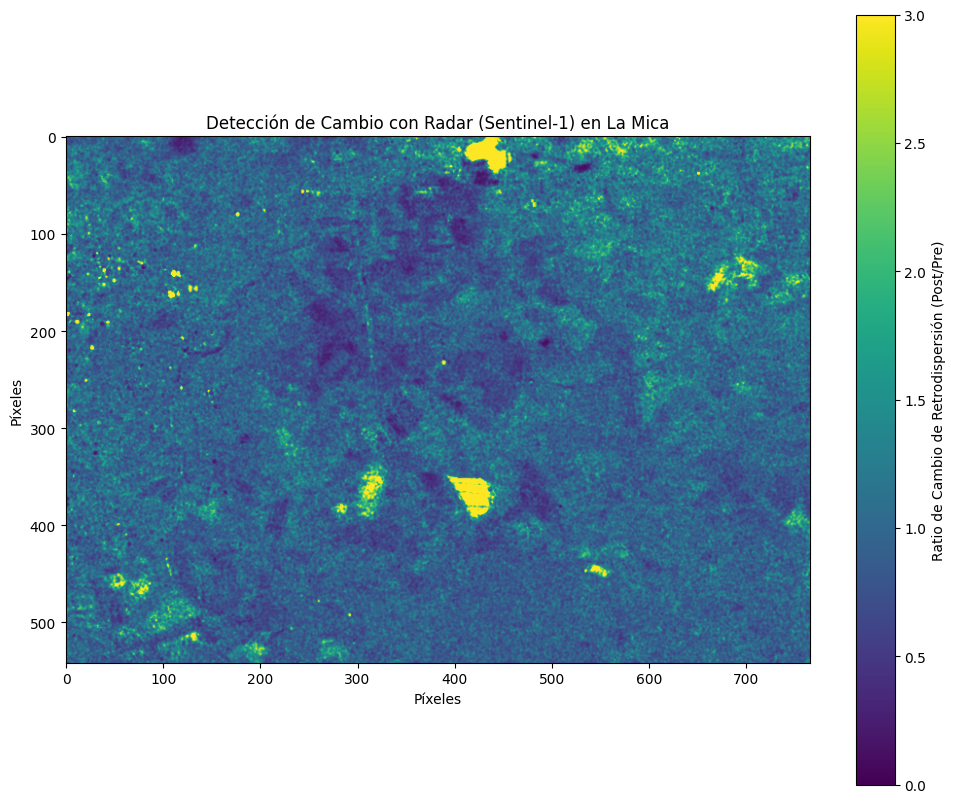

In [39]:
# Paso 7: Visualizar el resultado de Sentinel-1 (Cambio de Radar)
import numpy as np
print("\n--- Visualizando Resultados de Sentinel-1 ---")
print(f"Mostrando '{output_file_s1}'")
try:
    with rasterio.open(output_file_s1) as img:
        value_ratio = img.read(1)

        # Eliminar valores infinitos o no válidos que puedan resultar de la división
        value_ratio[~np.isfinite(value_ratio)] = 1.0

        # --- Graficar el ratio de cambio ---
        fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

        # Usamos un mapa de color que muestre bien las variaciones.
        # vmax=3 significa que estamos interesados en áreas donde la señal de radar se triplicó o más.
        im = ax.imshow(value_ratio, cmap='viridis', vmin=0, vmax=3)

        fig.colorbar(im, ax=ax, label="Ratio de Cambio de Retrodispersión (Post/Pre)")
        ax.set_title("Detección de Cambio con Radar (Sentinel-1) en La Mica")
        ax.set_xlabel("Píxeles")
        ax.set_ylabel("Píxeles")
        plt.show()
except Exception as e:
    print(f"No se pudo procesar el archivo de Sentinel-1: {e}")

Sentinel-2: 1 bandas, resolución: (10.0, 10.0)
Error durante la visualización: band index 10 out of range (not in (1,))
Tipo de error: IndexError

Intentando visualización básica...


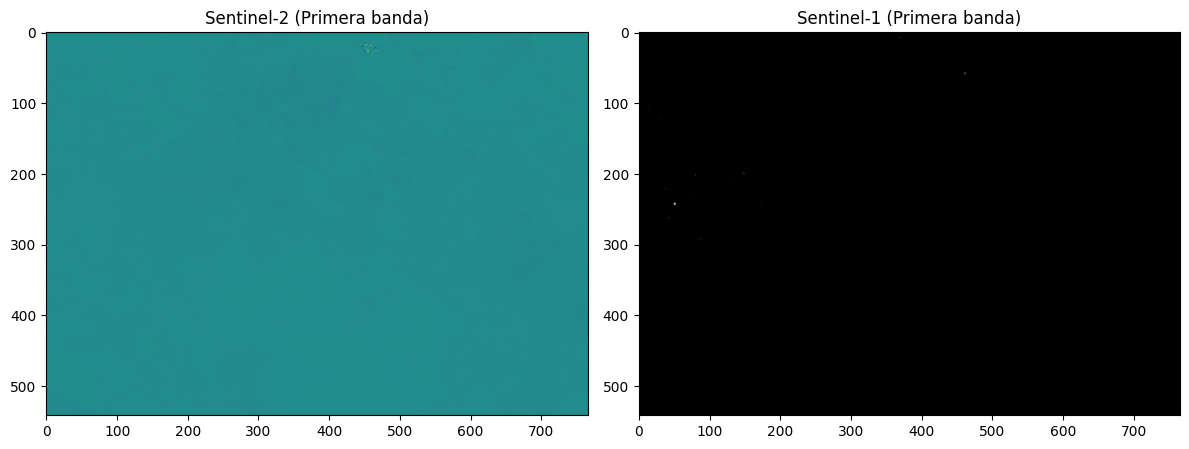

In [42]:
# Función para normalizar los datos de imagen
def normalize_image(data, percentile_range=(2, 98)):
    """Normalizar datos de imagen usando percentiles para mejor visualización"""
    if data.ndim > 2:
        # Para datos multibanda, normalizar cada banda por separado
        normalized = np.zeros_like(data, dtype=np.float32)
        for i in range(data.shape[0]):
            band_data = data[i]
            valid_data = band_data[np.isfinite(band_data)]
            if len(valid_data) > 0:
                p_low, p_high = np.percentile(valid_data, percentile_range)
                normalized[i] = np.clip((band_data - p_low) / (p_high - p_low), 0, 1)
        return normalized
    else:
        # Para datos de una sola banda
        valid_data = data[np.isfinite(data)]
        if len(valid_data) > 0:
            p_low, p_high = np.percentile(valid_data, percentile_range)
            return np.clip((data - p_low) / (p_high - p_low), 0, 1)
        return data

try:
    # Cargar imagen Sentinel-2
    with rasterio.open("NDVIDiff.tiff") as s2_img:
        # Obtener información sobre las bandas
        print(f"Sentinel-2: {s2_img.count} bandas, resolución: {s2_img.res}")

        # Orden de bandas según tu configuración OpenEO
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

        # Encontrar índices para las bandas de interés (B11=SWIR, B08=NIR, B04=Red)
        try:
            b11_idx = band_names.index('B11') + 1  # +1 para índice de rasterio
            b8_idx = band_names.index('B08') + 1
            b4_idx = band_names.index('B04') + 1

            # Leer las bandas individuales
            b11 = s2_img.read(b11_idx).astype(np.float32)
            b8 = s2_img.read(b8_idx).astype(np.float32)
            b4 = s2_img.read(b4_idx).astype(np.float32)

            # Crear composición RGB (SWIR-NIR-Red)
            s2_rgb = np.stack([b11, b8, b4], axis=0)

            # Normalizar para visualización
            s2_normalized = normalize_image(s2_rgb)

            # Transponer para matplotlib (height, width, channels)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

        except (ValueError, rasterio.errors.RasterioIOError) as e:
            print(f"Error procesando bandas S2: {e}")
            # Fallback: usar las primeras 3 bandas disponibles
            s2_rgb = s2_img.read([1, 2, 3]).astype(np.float32)
            s2_normalized = normalize_image(s2_rgb)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

    # Cargar imagen Sentinel-1
    with rasterio.open("S1_geografia_pre_evento.tiff") as s1_img:
        print(f"Sentinel-1: {s1_img.count} bandas, resolución: {s1_img.res}")

        # Leer banda VH (segunda banda si está disponible)
        if s1_img.count >= 2:
            s1_vh = s1_img.read(2).astype(np.float32)  # VH
        else:
            s1_vh = s1_img.read(1).astype(np.float32)  # VV como fallback

        # Manejar valores no finitos
        s1_vh = np.where(np.isfinite(s1_vh), s1_vh, np.nan)

    # Crear visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mostrar Sentinel-2 (composición RGB)
    axes[0].imshow(s2_display, aspect='auto')
    axes[0].set_title("Sentinel-2 (SWIR-NIR-Red)", fontsize=14)
    axes[0].set_xlabel("Píxeles X")
    axes[0].set_ylabel("Píxeles Y")
    axes[0].grid(True, alpha=0.3)

    # Mostrar Sentinel-1 (VH en escala de grises)
    im1 = axes[1].imshow(s1_vh, cmap='gray', vmin=np.nanpercentile(s1_vh, 5),
                         vmax=np.nanpercentile(s1_vh, 95), aspect='auto')
    axes[1].set_title("Sentinel-1 (VH)", fontsize=14)
    axes[1].set_xlabel("Píxeles X")
    axes[1].set_ylabel("Píxeles Y")
    axes[1].grid(True, alpha=0.3)

    # Agregar barra de color para Sentinel-1
    plt.colorbar(im1, ax=axes[1], label="Intensidad de Retrodispersión (VH)")

    plt.tight_layout()
    plt.show()

    # Mostrar información adicional
    print(f"\nInformación de las imágenes:")
    print(f"Sentinel-2 - Forma: {s2_display.shape}")
    print(f"Sentinel-1 - Forma: {s1_vh.shape}")
    print(f"Rango de valores S1-VH: {np.nanmin(s1_vh):.2f} a {np.nanmax(s1_vh):.2f}")

except Exception as e:
    print(f"Error durante la visualización: {e}")
    print(f"Tipo de error: {type(e).__name__}")

    # Visualización de fallback básica
    try:
        print("\nIntentando visualización básica...")

        with rasterio.open("NDVIDiff.tiff") as s2_img:
            s2_basic = s2_img.read(1)

        with rasterio.open("S1_geografia_pre_evento.tiff") as s1_img:
            s1_basic = s1_img.read(1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(s2_basic, cmap='viridis')
        axes[0].set_title("Sentinel-2 (Primera banda)")

        axes[1].imshow(s1_basic, cmap='gray')
        axes[1].set_title("Sentinel-1 (Primera banda)")

        plt.tight_layout()
        plt.show()

    except Exception as fallback_error:
        print(f"Error en visualización de fallback: {fallback_error}")


--- Visualizando Geografía del Terreno con Sentinel-1 ---


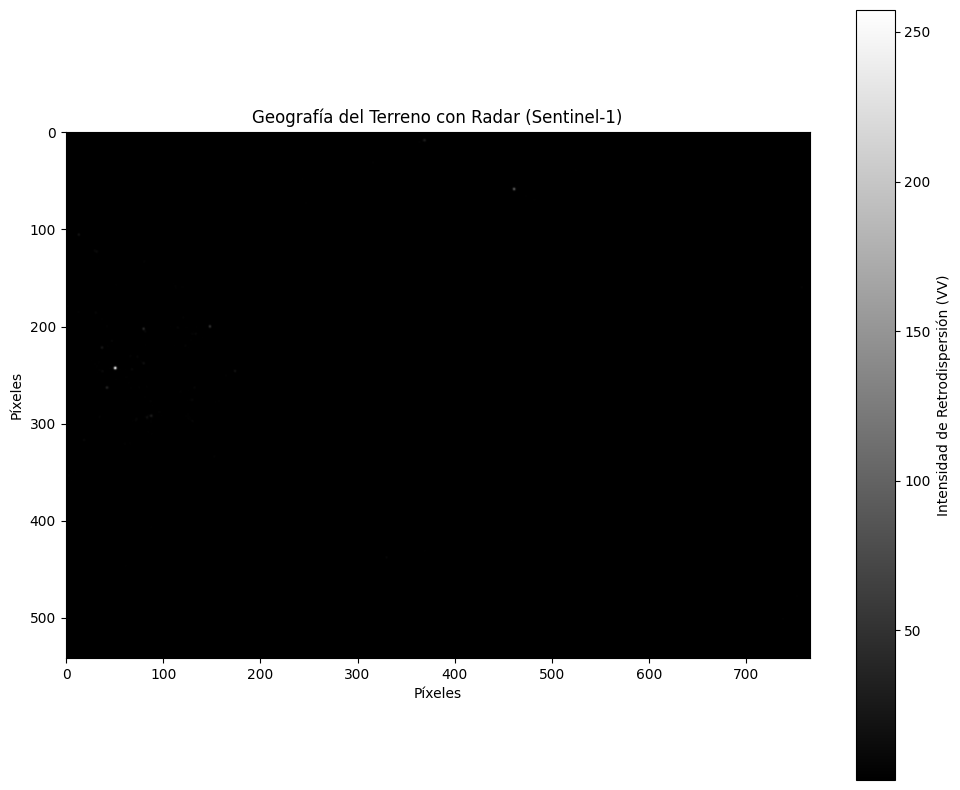

In [38]:
# Paso 8: Visualizar Geografía del Terreno (Radar)
print("\n--- Visualizando Geografía del Terreno con Sentinel-1 ---")
try:
    with rasterio.open(output_file_s1_geo) as img:
        value_geo = img.read(1)

        # --- Graficar la imagen de radar en escala de grises ---
        fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

        # El mapa de color 'gray' es ideal para este tipo de visualización
        im = ax.imshow(value_geo, cmap='gray')

        fig.colorbar(im, ax=ax, label="Intensidad de Retrodispersión (VV)")
        ax.set_title("Geografía del Terreno con Radar (Sentinel-1)")
        ax.set_xlabel("Píxeles")
        ax.set_ylabel("Píxeles")
        plt.show()
except Exception as e:
    print(f"No se pudo procesar el archivo geográfico de Sentinel-1: {e}")


# Zona Experimental

In [6]:
# Cargar la colección de datos Sentinel-2 (S2) en openEO
# Usaremos la colección Sentinel-2 Nivel 2A ya que proporciona datos corregidos atmosféricamente.
# Las bandas especificadas en el código de Earth Engine se mapean a las disponibles en L2A.
# Algunas bandas (como B1, B9, B10) pueden no estar directamente disponibles o tener diferente resolución
# en L2A comparado con L1C, pero seleccionaremos las más relevantes para un análisis general.
# Las bandas comunes para análisis multiespectral son B2, B3, B4, B8. Incluiré las bandas que tienen
# un equivalente directo o similar en L2A.
print("\n--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---")
s2_collection_openeo = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_pre, # Usamos el rango temporal pre-evento definido anteriormente
    spatial_extent=spatial_extent,     # Usamos el área de interés definida anteriormente
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'] # Seleccionar bandas relevantes en L2A
)
s2_allBand = s2_collection_openeo.mean_time()
print("Iniciando descarga de imagen promediada en el tiempo....")
s2_allBand.download("sentinel2_collection_pre_event.tiff")


print("\n--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---")
# Cargar la colección de datos de Radar Sentinel-1 (GRD)
s1_collection_openeo = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=['VV', 'VH']
)
s1_allBand = s1_collection_openeo.mean_time()
print("Iniciando descarga de imagen promediada en el tiempo....")
s1_allBand.download("sentinel1_collection_pre_event.tiff")



--- Iniciando Flujo de Trabajo para Sentinel-2 (S2) con OpenEO ---
Iniciando descarga de imagen promediada en el tiempo....

--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---
Iniciando descarga de imagen promediada en el tiempo....



--- Visualizando Resultados de Sentinel-1 ---


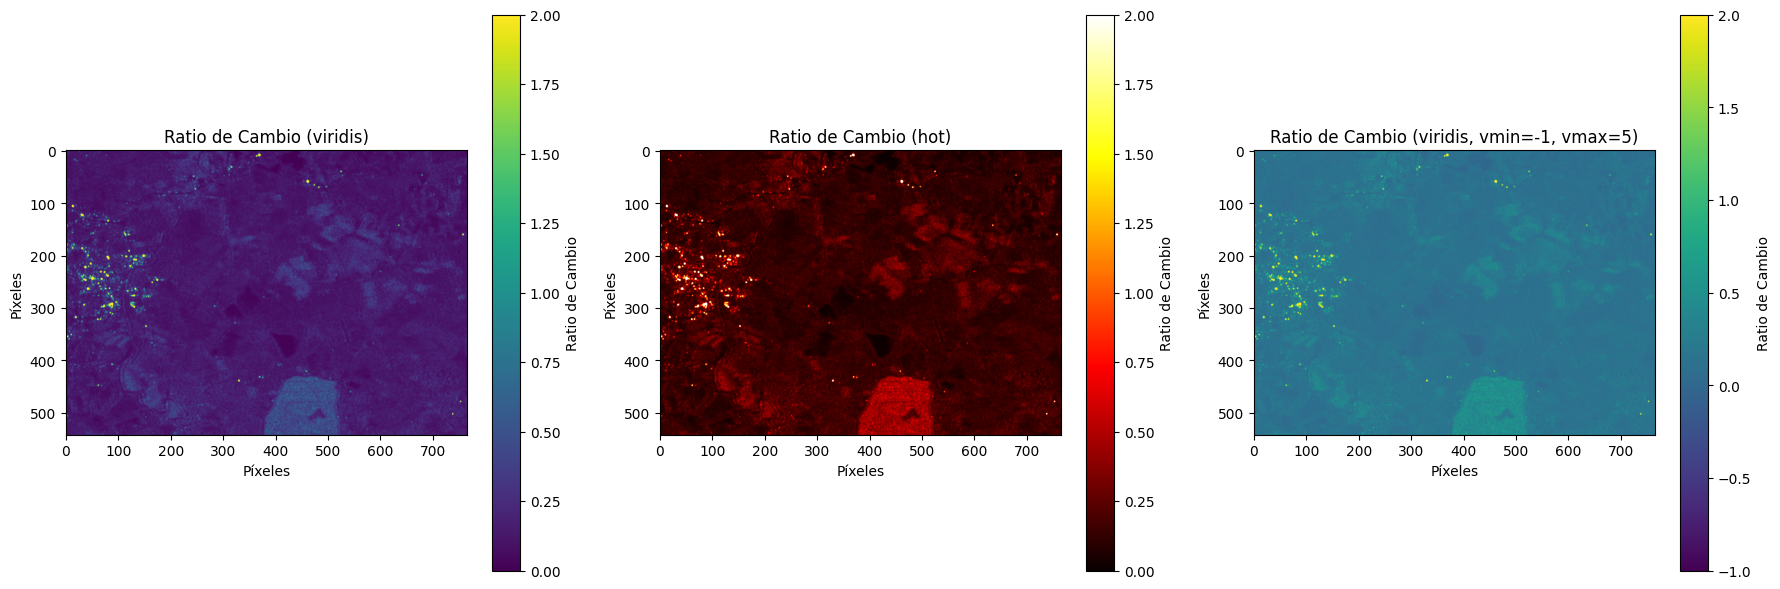

In [33]:
# Paso 7: Visualizar el resultado de Sentinel-1 (Cambio de Radar)
import numpy as np
import rasterio
import matplotlib.pyplot as plt

print("\n--- Visualizando Resultados de Sentinel-1 ---")
output_file_s1 = "sentinel1_collection_pre_event.tiff" # Assuming this is the file from cell 8NKJhKxNGQt7
vminG = 0
vmaxG = 2

try:
    with rasterio.open(output_file_s1) as img:
        # Read the data from the first band (assuming the change ratio is in the first band)
        value_ratio = img.read(1)

        # Handle non-finite values (NaN or Inf) that might result from division by zero or invalid data
        # Replace with a value that doesn't interfere with visualization, e.g., 1.0 for ratio
        value_ratio[~np.isfinite(value_ratio)] = 1.0

        # --- Create Subplots for Comparison ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100) # 1 row, 3 columns

        # Plot 1: Original visualization (viridis cmap, vmin=0, vmax=3)
        im1 = axes[0].imshow(value_ratio, cmap='viridis', vmin=vminG, vmax=vmaxG)
        fig.colorbar(im1, ax=axes[0], label="Ratio de Cambio")
        axes[0].set_title("Ratio de Cambio (viridis)")
        axes[0].set_xlabel("Píxeles")
        axes[0].set_ylabel("Píxeles")

        # Plot 2: Using a different colormap (e.g., hot)
        im2 = axes[1].imshow(value_ratio, cmap='hot', vmin=vminG, vmax=vmaxG)
        fig.colorbar(im2, ax=axes[1], label="Ratio de Cambio")
        axes[1].set_title("Ratio de Cambio (hot)")
        axes[1].set_xlabel("Píxeles")
        axes[1].set_ylabel("Píxeles")

        # Plot 3: Adjusting the value range (e.g., vmin=0, vmax=5 to see higher changes)
        im3 = axes[2].imshow(value_ratio, cmap='viridis', vmin=-1, vmax=2)
        fig.colorbar(im3, ax=axes[2], label="Ratio de Cambio")
        axes[2].set_title("Ratio de Cambio (viridis, vmin=-1, vmax=5)")
        axes[2].set_xlabel("Píxeles")
        axes[2].set_ylabel("Píxeles")


        plt.tight_layout() # Adjust layout to prevent titles/labels overlapping
        plt.show()

except rasterio.errors.RasterioIOError as e:
    print(f"Error al cargar el archivo TIFF '{output_file_s1}': {e}")
    print("Asegúrate de que el archivo se descargó correctamente en el paso anterior.")
except Exception as e:
    print(f"Ocurrió un error durante la visualización: {e}")


Sentinel-2: 11 bandas, resolución: (10.0, 10.0)
Sentinel-1: 2 bandas, resolución: (10.0, 10.0)


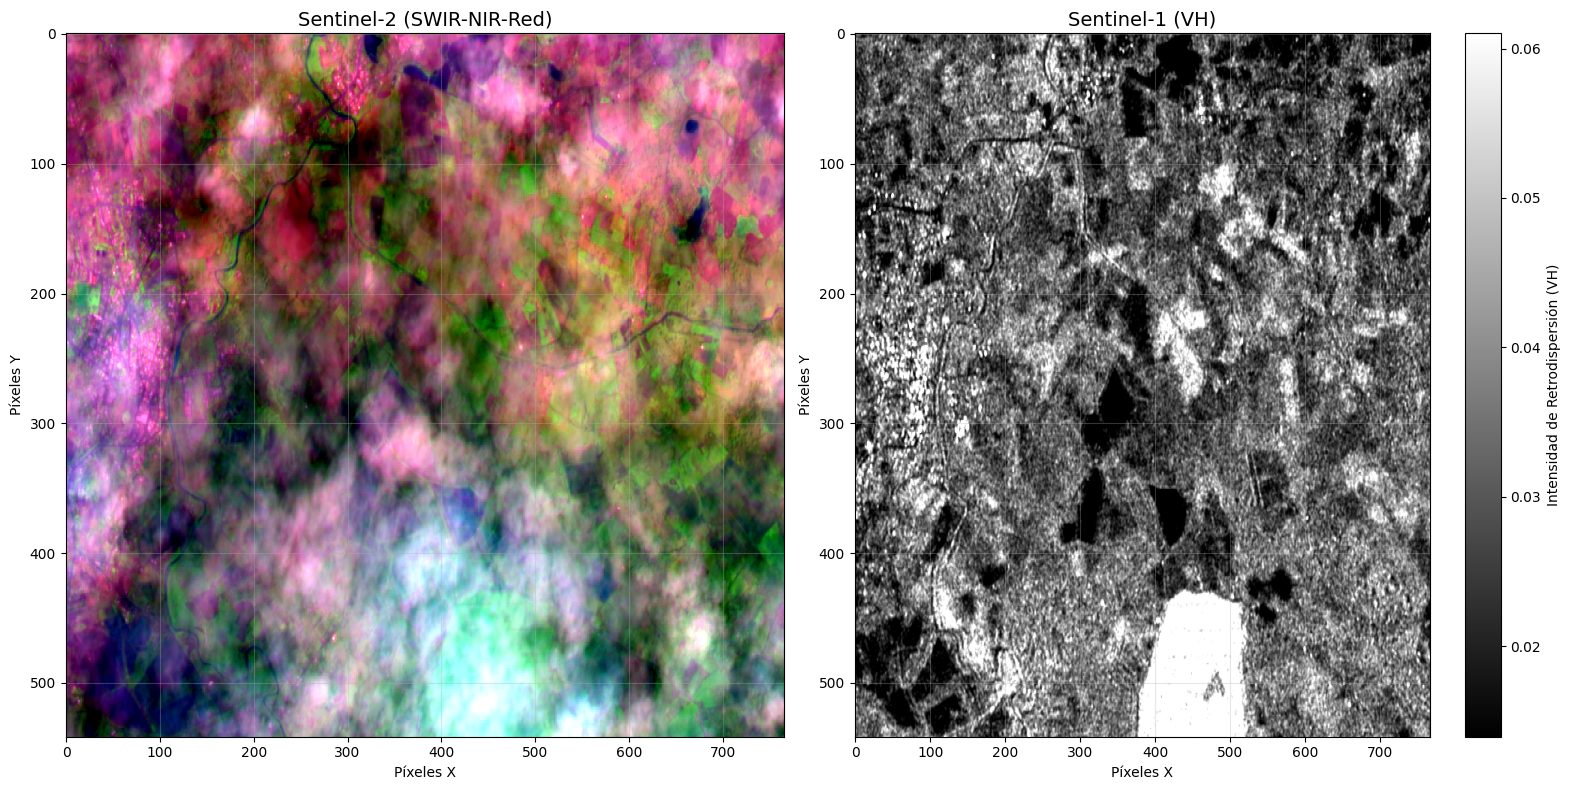


Información de las imágenes:
Sentinel-2 - Forma: (542, 766, 3)
Sentinel-1 - Forma: (542, 766)
Rango de valores S1-VH: 0.00 a 18.23


In [32]:
# Función para normalizar los datos de imagen
def normalize_image(data, percentile_range=(2, 98)):
    """Normalizar datos de imagen usando percentiles para mejor visualización"""
    if data.ndim > 2:
        # Para datos multibanda, normalizar cada banda por separado
        normalized = np.zeros_like(data, dtype=np.float32)
        for i in range(data.shape[0]):
            band_data = data[i]
            valid_data = band_data[np.isfinite(band_data)]
            if len(valid_data) > 0:
                p_low, p_high = np.percentile(valid_data, percentile_range)
                normalized[i] = np.clip((band_data - p_low) / (p_high - p_low), 0, 1)
        return normalized
    else:
        # Para datos de una sola banda
        valid_data = data[np.isfinite(data)]
        if len(valid_data) > 0:
            p_low, p_high = np.percentile(valid_data, percentile_range)
            return np.clip((data - p_low) / (p_high - p_low), 0, 1)
        return data

try:
    # Cargar imagen Sentinel-2
    with rasterio.open("sentinel2_collection_pre_event.tiff") as s2_img:
        # Obtener información sobre las bandas
        print(f"Sentinel-2: {s2_img.count} bandas, resolución: {s2_img.res}")

        # Orden de bandas según tu configuración OpenEO
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

        # Encontrar índices para las bandas de interés (B11=SWIR, B08=NIR, B04=Red)
        try:
            b11_idx = band_names.index('B11') + 1  # +1 para índice de rasterio
            b8_idx = band_names.index('B08') + 1
            b4_idx = band_names.index('B04') + 1

            # Leer las bandas individuales
            b11 = s2_img.read(b11_idx).astype(np.float32)
            b8 = s2_img.read(b8_idx).astype(np.float32)
            b4 = s2_img.read(b4_idx).astype(np.float32)

            # Crear composición RGB (SWIR-NIR-Red)
            s2_rgb = np.stack([b11, b8, b4], axis=0)

            # Normalizar para visualización
            s2_normalized = normalize_image(s2_rgb)

            # Transponer para matplotlib (height, width, channels)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

        except (ValueError, rasterio.errors.RasterioIOError) as e:
            print(f"Error procesando bandas S2: {e}")
            # Fallback: usar las primeras 3 bandas disponibles
            s2_rgb = s2_img.read([1, 2, 3]).astype(np.float32)
            s2_normalized = normalize_image(s2_rgb)
            s2_display = np.transpose(s2_normalized, (1, 2, 0))

    # Cargar imagen Sentinel-1
    with rasterio.open("sentinel1_collection_pre_event.tiff") as s1_img:
        print(f"Sentinel-1: {s1_img.count} bandas, resolución: {s1_img.res}")

        # Leer banda VH (segunda banda si está disponible)
        if s1_img.count >= 2:
            s1_vh = s1_img.read(2).astype(np.float32)  # VH
        else:
            s1_vh = s1_img.read(1).astype(np.float32)  # VV como fallback

        # Manejar valores no finitos
        s1_vh = np.where(np.isfinite(s1_vh), s1_vh, np.nan)

    # Crear visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Mostrar Sentinel-2 (composición RGB)
    axes[0].imshow(s2_display, aspect='auto')
    axes[0].set_title("Sentinel-2 (SWIR-NIR-Red)", fontsize=14)
    axes[0].set_xlabel("Píxeles X")
    axes[0].set_ylabel("Píxeles Y")
    axes[0].grid(True, alpha=0.3)

    # Mostrar Sentinel-1 (VH en escala de grises)
    im1 = axes[1].imshow(s1_vh, cmap='gray', vmin=np.nanpercentile(s1_vh, 5),
                         vmax=np.nanpercentile(s1_vh, 95), aspect='auto')
    axes[1].set_title("Sentinel-1 (VH)", fontsize=14)
    axes[1].set_xlabel("Píxeles X")
    axes[1].set_ylabel("Píxeles Y")
    axes[1].grid(True, alpha=0.3)

    # Agregar barra de color para Sentinel-1
    plt.colorbar(im1, ax=axes[1], label="Intensidad de Retrodispersión (VH)")

    plt.tight_layout()
    plt.show()

    # Mostrar información adicional
    print(f"\nInformación de las imágenes:")
    print(f"Sentinel-2 - Forma: {s2_display.shape}")
    print(f"Sentinel-1 - Forma: {s1_vh.shape}")
    print(f"Rango de valores S1-VH: {np.nanmin(s1_vh):.2f} a {np.nanmax(s1_vh):.2f}")

except Exception as e:
    print(f"Error durante la visualización: {e}")
    print(f"Tipo de error: {type(e).__name__}")

    # Visualización de fallback básica
    try:
        print("\nIntentando visualización básica...")

        with rasterio.open("sentinel2_collection_pre_event.tiff") as s2_img:
            s2_basic = s2_img.read(1)

        with rasterio.open("sentinel1_collection_pre_event.tiff") as s1_img:
            s1_basic = s1_img.read(1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(s2_basic, cmap='viridis')
        axes[0].set_title("Sentinel-2 (Primera banda)")

        axes[1].imshow(s1_basic, cmap='gray')
        axes[1].set_title("Sentinel-1 (Primera banda)")

        plt.tight_layout()
        plt.show()

    except Exception as fallback_error:
        print(f"Error en visualización de fallback: {fallback_error}")

Ocurrió un error durante la visualización: 'DataArray' object has no attribute 'bounds'


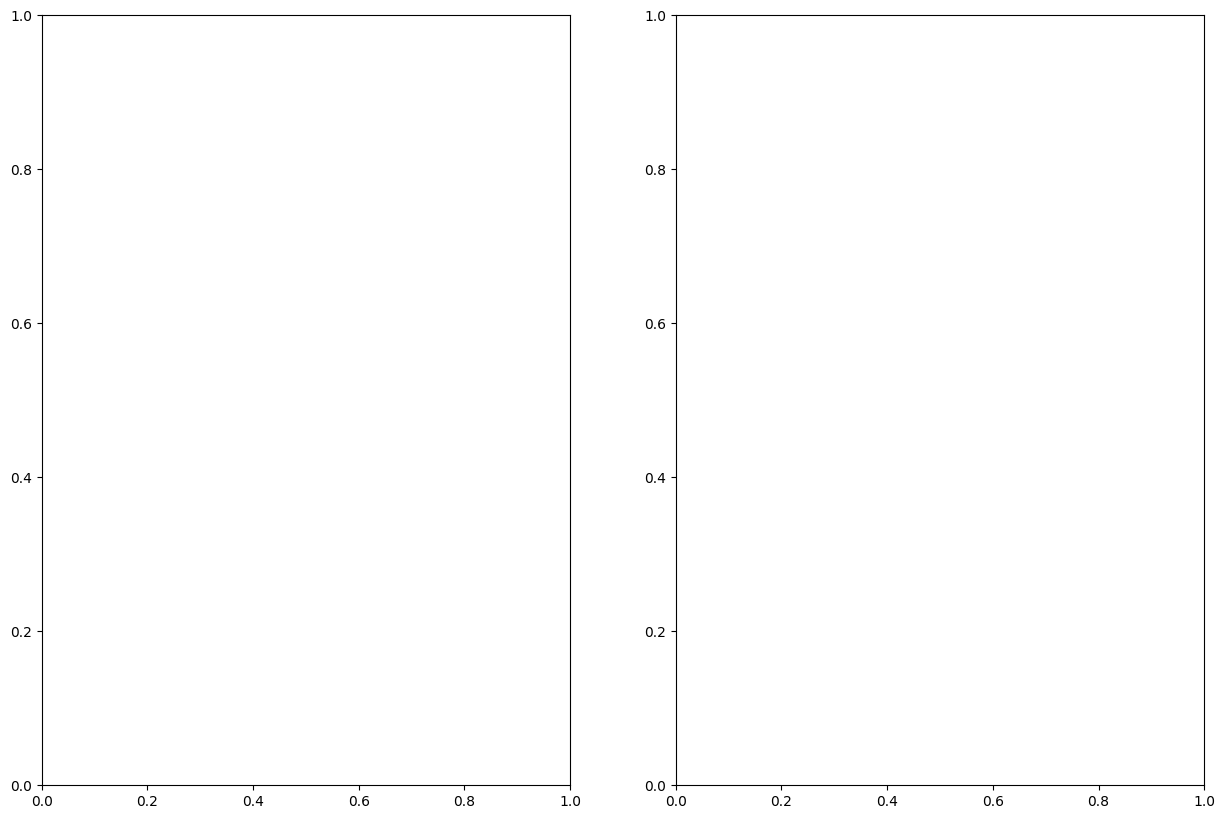

In [ ]:
from georeader.plot import show # Volvemos a usar show de georeader
import xarray as xr # Aseguramos la importación de xarray

# Cargar las imágenes descargadas con openEO
try:
    with rasterio.open("sentinel2_collection_pre_event.tiff") as s2_img_openeo:
        # Preparar la imagen Sentinel-2 para visualización (similar a la combinación SWIR-NIR-Red del ejemplo EE)
        # Necesitamos identificar los índices de las bandas B11, B8 y B4 en el archivo TIFF de salida de openEO.
        # openEO generalmente exporta las bandas en el orden en que fueron solicitadas.
        # Asegúrate de que el orden de las bandas en 'bands' en la descarga de S2 (celda 26978073) coincida.
        # Si las bandas en 'bands' son ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'],
        # entonces los índices serán (base 1): B4: 3, B8: 7, B11: 9.
        # Ajusta los índices si el orden de tus bandas es diferente.
        # Los índices en Python son base 0, así que restamos 1: B4: 2, B8: 6, B11: 8
        band_indices_swir_nir_red_0based = [8, 6, 2] # Índices base 0 para B11, B8, B4

        # Leer las bandas necesarias (Rasterio lee en formato C [band, row, col])
        s2_bands_data = [s2_img_openeo.read(band_indices_swir_nir_red_0based[0] + 1), # +1 porque rasterio usa índices base 1
                         s2_img_openeo.read(band_indices_swir_nir_red_0based[1] + 1),
                         s2_img_openeo.read(band_indices_swir_nir_red_0based[2] + 1)]

        # Crear DataArray para Sentinel-2
        # Usamos las coordenadas y la transformación de rasterio para georreferenciar el DataArray
        # Necesitamos aplanar las bandas leídas para que el DataArray tenga la forma (band, y, x)
        # Usar s2_img_openeo.res para obtener la resolución (xres, yres)
        s2_xres, s2_yres = s2_img_openeo.res

        # Acceder directamente al atributo bounds
        s2_bounds = s2_img_openeo.bounds


        s2_visual_da = xr.DataArray(
            np.stack(s2_bands_data, axis=0), # Stack para obtener forma (band, y, x)
            coords={'band': ['B11', 'B8', 'B4'], 'y': s2_yres * np.arange(s2_img_openeo.height) + s2_bounds.top, 'x': s2_xres * np.arange(s2_img_openeo.width) + s2_bounds.left},
            dims=['band', 'y', 'x'],
            attrs={'crs': s2_img_openeo.crs, 'transform': s2_img_openeo.transform}
        )

        # Normalizar los valores de las bandas. El rango de valores puede variar.
        s2_visual_normalized = (s2_visual_da / 4500.0).clip(0, 1)


    with rasterio.open("sentinel1_collection_pre_event.tiff") as s1_img_openeo:
        # Preparar la imagen Sentinel-1 para visualización (polarización VH, escala de grises)
        # Asumiendo que 'VH' fue la segunda banda solicitada en la descarga de S1 (celda 26978073), su índice es 1 (+1 para rasterio)
        s1_band_data = s1_img_openeo.read(2) # Lee la segunda banda (VH)

        # Crear DataArray para Sentinel-1
        # Usar s1_img_openeo.res para obtener la resolución (xres, yres)
        s1_xres, s1_yres = s1_img_openeo.res

        # Acceder directamente al atributo bounds
        s1_bounds = s1_img_openeo.bounds


        s1_visual_da = xr.DataArray(
            s1_band_data,
             coords={'y': s1_yres * np.arange(s1_img_openeo.height) + s1_bounds.top, 'x': s1_xres * np.arange(s1_img_openeo.width) + s1_bounds.left},
            dims=['y', 'x'],
            attrs={'crs': s1_img_openeo.crs, 'transform': s1_img_openeo.transform}
        )

        # Manejar posibles valores no finitos (NaN, Inf) que pueden causar problemas de visualización
        s1_visual_da = s1_visual_da.where(np.isfinite(s1_visual_da), np.nan)


    # Visualizar las imágenes una al lado de la otra
    fig, ax = plt.subplots(1, 2, figsize=(15, 10)) # Aumentar el tamaño de la figura para mejor visualización

    # Mostrar la composición de Sentinel-2 usando georeader.plot.show
    show(s2_visual_normalized, ax=ax[0])
    ax[0].set_title("Composición Sentinel-2 (SWIR-NIR-Red)")
    ax[0].set_xlabel("Coordenadas X")
    ax[0].set_ylabel("Coordenadas Y")

    # Mostrar la banda VH de Sentinel-1 en escala de grises usando georeader.plot.show
    # Aplicar el rango de visualización (vmin, vmax) similar al ejemplo EE
    im1 = show(s1_visual_da, cmap="gray", vmin=-25, vmax=-5, ax=ax[1])
    ax[1].set_title("Sentinel-1 (VH)")
    ax[1].set_xlabel("Coordenadas X")
    ax[1].set_ylabel("Coordenadas Y")

    # Agregar una barra de color para la imagen de Sentinel-1
    fig.colorbar(im1, ax=ax[1], label="Intensidad de Retrodispersión (VH)")


    plt.tight_layout() # Ajustar el diseño para evitar solapamiento
    plt.show()

except rasterio.errors.RasterioIOError as e:
    print(f"Error al cargar uno de los archivos TIFF: {e}")
    print("Asegúrate de que los archivos 'sentinel2_collection_pre_event.tiff' y 'sentinel1_collection_pre_event.tiff' se descargaron correctamente.")
except Exception as e:
    print(f"Ocurrió un error durante la visualización: {e}")

# Notas sobre las advertencias de Rasterio:
# Las advertencias "TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel"
# suelen indicar que el archivo GeoTIFF tiene metadatos que describen el número de canales (bands)
# de una manera que Rasterio interpreta como "canales de color" más "canales extra",
# y la suma no coincide con el número total de SamplePerPixel en el archivo.
# Rasterio maneja esto definiendo los canales que no son de color como ExtraSamples.
# Generalmente, estas advertencias no impiden la lectura de los datos, solo informan sobre
# una potencial ambigüedad en la interpretación de los metadatos TIFF, especialmente con archivos
# multibanda no estándar o con ciertos tipos de compresión/metadatos.
# En este caso, es probable que se deba a cómo openEO exporta los archivos multibanda.

In [ ]:
## Ejemplos
from georeader.read import read_reproject_like
## DOWNLOAD S2 IMAGE
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20180519T101031_N0206_R022_T34WFU_20180519T120709"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
img_local_s2 = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=bands,
                                            geometry=aoi)


## DOWNLOAD S1 IMAGE
collection_name = "COPERNICUS/S1_GRD"
tile = "S1A_IW_GRDH_1SDV_20180519T050449_20180519T050514_021969_025F61_90E6"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("system:index", tile)).first()
info_img = image.getInfo()
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
img_local_s1 = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=['VV', 'VH'],
                                            geometry=aoi)

img_local_s1 = read_reproject_like(img_local_s1, img_local_s2)
## Mostrar imágenes
from georeader.plot import show
swirnirred = (img_local_s2.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

fig, ax = plt.subplots(1,2,figsize=(10, 10))
show(swirnirred, ax = ax[0])

show(img_local_s1.isel({"band": [1]}), cmap="gray", vmin=-25, vmax=-5, ax=ax[1])

plt.show()